# Test Clustertools with AMUSE data

First, make sure the packages are installed / up-to-date

In [1]:
! pip install --upgrade pip
! pip install --upgrade amuse-framework
! pip install --upgrade clustertools
! pip install --upgrade galpy

Import packages

In [2]:
import numpy as np
import clustertools as ct
from amuse.units import units, nbody_system, constants
from amuse.io import read_set_from_file
from amuse.support.console import set_printing_strategy
from amuse.ic.plummer import new_plummer_model
from amuse.ic.kroupa import new_kroupa_mass_distribution
set_printing_strategy('custom', preferred_units=[units.pc, units.Myr, units.kms])

Create a star cluster model

In [3]:
number_of_stars = 3000
masses = new_kroupa_mass_distribution(number_of_stars)
cluster_radius = 2 | units.pc
converter = nbody_system.nbody_to_si(cluster_radius, masses.sum())
stars_initial = new_plummer_model(number_of_stars, converter)
stars_initial.mass = masses

Create a galactic potential model to put the cluster in orbit of

In [4]:
class SimpleGalacticModel:
    def __init__(self, radius=1 | units.kpc, mass=1.5e10 | units.MSun, alpha=1.2):
        self.radius = radius
        self.mass = mass
        self.alpha = alpha

    def get_gravity_at_point(self, epsilon, x, y, z):
        r2 = x**2 + y**2 + z**2 + epsilon**2
        r = r2**0.5
        m = self.mass * (r/self.radius)**self.alpha
        fr = constants.G * m / r2
        ax = -fr * x / r
        ay = -fr * y / r
        az = -fr * z / r
        return ax, ay, az

    def circular_velocity(self, distance):
        m = self.mass * (distance / self.radius)**self.alpha
        vc = (constants.G * m/distance)**0.5
        return vc

    def get_potential_at_point(self, epsilon, x, y, z):
        r2 = x**2 + y**2 + z**2 + epsilon**2
        r = r2**0.5
        c = constants.G * self.mass / self.radius**self.alpha
        phi = c / (self.alpha-1) * (r**(self.alpha-1) - self.radius**(self.alpha-1))
        return phi

Put the cluster in orbit

In [5]:
galaxy = SimpleGalacticModel()
cluster_distance = 100 | units.pc
stars_initial.x += cluster_distance
stars_initial.vy += 0.8 * galaxy.circular_velocity(cluster_distance)

Manually add stars to ClusterTools (keeping units)

In [6]:
cluster = ct.StarCluster(ctype='amuse', origin='galaxy')
s = stars_initial
cluster.add_stars(s.x, s.y, s.z, s.vx, s.vy, s.vz, s.mass, s.key)

cluster.analyze(sortstars=True)

**starplot cannot handle AMUSE units, so the cell below fails**

<class 'ValueError'> setting an array element with a sequence.
This is caused by an AMUSE quantity being treated as a Numpy array


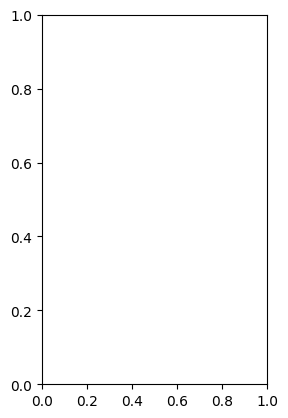

In [10]:
try:
    ct.starplot(cluster)
except ValueError as err:
    print(ValueError, err)
    print("This is caused by an AMUSE quantity being treated as a Numpy array")

Alternative: directly load AMUSE cluster (this seems to get rid of the AMUSE units)

0

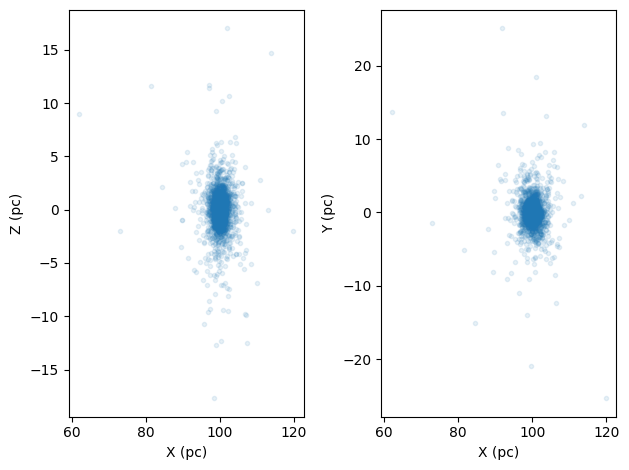

In [11]:
cluster_direct = ct.load_cluster('amuse', particles=stars_initial, units='pckms', origin='galaxy')
cluster_direct.analyze(sortstars=True)
ct.starplot(cluster_direct)

In [15]:
# We can add the orbit here, but I'm not 100% sure what it does so ignoring it for now
# cluster.add_orbit(
#     0 | units.pc, cluster_distance, 0 | units.pc,
#     0 | units.kms, 0.8 * galaxy.circular_velocity(cluster_distance), 0 | units.kms
# )

In [16]:
def ct_vs_amuse(
    ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz,
    am_x, am_y, am_z, am_vx, am_vy, am_vz,
):
    print(
        f"Clustertools finds position/velocity: {ct_x}, {ct_y}, {ct_z}, {ct_vx}, {ct_vy}, {ct_vz}"
    )
    print(
        f"Difference in position (vs center-of-mass): {ct_x-am_x}, {ct_y-am_y}, {ct_z-am_z}\n"
        f"Difference in velocity (vs center-of-mass): {ct_vx-am_vx}, {ct_vy-am_vy}, {ct_vz-am_vz}\n"
    )

In [17]:
ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz = cluster.find_centre()
am_x, am_y, am_z = stars_initial.center_of_mass()
am_vx, am_vy, am_vz = stars_initial.center_of_mass_velocity()
dc, cr, crho = stars_initial.densitycentre_coreradius_coredens(unit_converter=converter)
am_dx, am_dy, am_dz = dc
print("CT vs AMUSE center-of-mass:")
ct_vs_amuse(
    ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz,
    am_x, am_y, am_z, am_vx, am_vy, am_vz,
)
print("CT vs AMUSE density center (with Hop, ignore the velocities):")
ct_vs_amuse(
    ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz,
    am_dx, am_dy, am_dz, am_vx, am_vy, am_vz,
)

CT vs AMUSE center-of-mass:
Clustertools finds position/velocity: 99.3209800398 parsec, 0.470005260332 parsec, 0.124030076442 parsec, -0.0763412494321 kms, 161.00858176 kms, 0.461653361487 kms
Difference in position (vs center-of-mass): -0.499100313496 parsec, 0.38015984691 parsec, 0.175113415496 parsec
Difference in velocity (vs center-of-mass): -0.0660607150814 kms, -0.33419662779 kms, 0.345459421207 kms

CT vs AMUSE density center (with Hop, ignore the velocities):
Clustertools finds position/velocity: 99.3209800398 parsec, 0.470005260332 parsec, 0.124030076442 parsec, -0.0763412494321 kms, 161.00858176 kms, 0.461653361487 kms
Difference in position (vs center-of-mass): -0.625009134083 parsec, 0.471941228118 parsec, 0.129272244149 parsec
Difference in velocity (vs center-of-mass): -0.0660607150814 kms, -0.33419662779 kms, 0.345459421207 kms



**Weird / bug: running the cell above a second time finds the cluster at the origin?**

(this problem does not occur when using the code in the cell below)

In [18]:
ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz = ct.find_centre(cluster)
try:
    print(f"Positions are in unit {ct_x.unit}")
except:
    print(f"Not using units - assuming pc/kms")
    ct_x , ct_y, ct_z, ct_vx, ct_vy, ct_vz = ct_x | units.pc, ct_y | units.pc, ct_z | units.pc, ct_vx | units.kms, ct_vy | units.kms, ct_vz | units.kms,

print("CT vs AMUSE center-of-mass:")
ct_vs_amuse(
    ct_x , ct_y, ct_z, ct_vx, ct_vy, ct_vz,
    am_x, am_y, am_z, am_vx, am_vy, am_vz,
)
print("CT vs AMUSE density center (with Hop, ignore the velocities):")
ct_vs_amuse(
    ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz,
    am_dx, am_dy, am_dz, am_vx, am_vy, am_vz,
)

Positions are in unit parsec
CT vs AMUSE center-of-mass:
Clustertools finds position/velocity: 99.3209800398 parsec, 0.470005260332 parsec, 0.124030076442 parsec, -0.0763412494321 kms, 161.00858176 kms, 0.461653361487 kms
Difference in position (vs center-of-mass): -0.499100313496 parsec, 0.38015984691 parsec, 0.175113415496 parsec
Difference in velocity (vs center-of-mass): -0.0660607150814 kms, -0.33419662779 kms, 0.345459421207 kms

CT vs AMUSE density center (with Hop, ignore the velocities):
Clustertools finds position/velocity: 99.3209800398 parsec, 0.470005260332 parsec, 0.124030076442 parsec, -0.0763412494321 kms, 161.00858176 kms, 0.461653361487 kms
Difference in position (vs center-of-mass): -0.625009134083 parsec, 0.471941228118 parsec, 0.129272244149 parsec
Difference in velocity (vs center-of-mass): -0.0660607150814 kms, -0.33419662779 kms, 0.345459421207 kms



**Using the center-of-mass in Clustertools seems to ignore the galactic coordinates?**

In [19]:
# alternatively, find the center-of-mass rather than density center:
ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz = cluster.find_centre(density=False)
print("CT center-of-mass vs AMUSE center-of-mass:")
ct_vs_amuse(
    ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz,
    am_x, am_y, am_z, am_vx, am_vy, am_vz,
)
print("CT center-of-mass vs AMUSE density center (with Hop, ignore the velocities):")
ct_vs_amuse(
    ct_x, ct_y, ct_z, ct_vx, ct_vy, ct_vz,
    am_dx, am_dy, am_dz, am_vx, am_vy, am_vz,
)

CT center-of-mass vs AMUSE center-of-mass:
Clustertools finds position/velocity: 0.499100313496 parsec, -0.38015984691 parsec, -0.175113415496 parsec, 0.0660607150814 kms, 0.33419662779 kms, -0.345459421207 kms
Difference in position (vs center-of-mass): -99.3209800398 parsec, -0.470005260332 parsec, -0.124030076442 parsec
Difference in velocity (vs center-of-mass): 0.0763412494321 kms, -161.00858176 kms, -0.461653361487 kms

CT center-of-mass vs AMUSE density center (with Hop, ignore the velocities):
Clustertools finds position/velocity: 0.499100313496 parsec, -0.38015984691 parsec, -0.175113415496 parsec, 0.0660607150814 kms, 0.33419662779 kms, -0.345459421207 kms
Difference in position (vs center-of-mass): -99.4468888603 parsec, -0.378223879124 parsec, -0.169871247789 parsec
Difference in velocity (vs center-of-mass): 0.0763412494321 kms, -161.00858176 kms, -0.461653361487 kms



In [20]:
print('Half-Mass Relaxation Time: ', cluster.half_mass_relaxation_time())
print('Half-Mass Relaxation Time: ', cluster_direct.half_mass_relaxation_time())
print('Core Relaxation Time: ', cluster.core_relaxation_time())
print('Core Relaxation Time: ', cluster_direct.core_relaxation_time())
print('Lagrange Radii: ', cluster.rlagrange())
print('Lagrange Radii: ', cluster_direct.rlagrange())
print('Virial Radius: ', cluster.virial_radius())
print('Virial Radius: ', cluster_direct.virial_radius())

Half-Mass Relaxation Time:  45.9448246587 Myr
Half-Mass Relaxation Time:  55.0388417941
Core Relaxation Time:  23.9785474416 Myr
Core Relaxation Time:  32.7386016327
Lagrange Radii:  [0.653974503222, 0.870080484497, 1.01169934665, 1.2151316387, 1.47316428774, 1.88993947013, 2.37806087275, 3.1976523937, 4.52711199722, 41.0922449413] parsec
Lagrange Radii:  [0.38671639552634757, 0.80944868232689282, 1.1782641668747769, 1.427138268702322, 1.6616503399836804, 2.0234363208067627, 2.5913945888612999, 3.4585218036513705, 4.8190833586635353, 40.472159964789206]
Virial Radius:  2.02778970538 parsec
Virial Radius:  2.02778970538


- Why is this result different for cluster and cluster_direct? It's the same data...
- also, the AMUSE-fed data has units while AMUSE-loaded data has not?

**Skyplot seems to work even for data that has units (probably because they are removed when converting to sky coordinates). But the time still has a unit and causes a TypeError.**

<class 'TypeError'> must be real number, not ScalarQuantity
Again, AMUSE quantity is used as a number


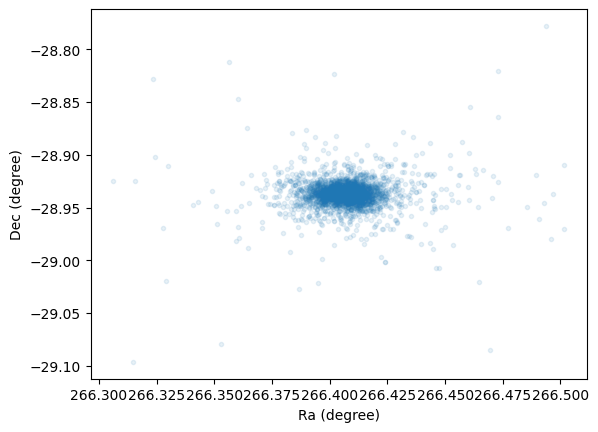

In [22]:
try:
    ct.skyplot(cluster)
except TypeError as err:
    print(TypeError, err)
    print("Again, AMUSE quantity is used as a number")

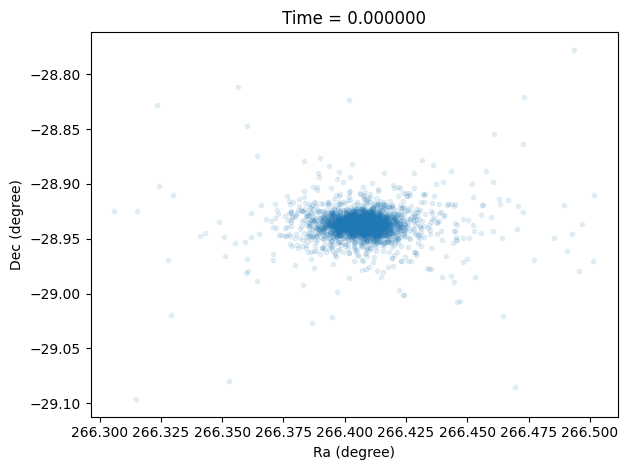

In [23]:
ct.skyplot(cluster_direct)

**So it seems Clustertools has some trouble with AMUSE units. I wonder how it deals with Astropy units (untested)?**

In [24]:
print('Mean radius with numpy =', np.mean(cluster.r))
print('Mean radius =', cluster.rmean)

print('Half mass radius =', cluster.rm)

cluster.rlagrange()
print('50% Lagrange Radius = ',cluster.rn[4])

Mean radius with numpy = 100.034608114 parsec
Mean radius = 100.034608114 parsec
Half mass radius = 99.8574071408 parsec
50% Lagrange Radius =  198.607644384 parsec


In [25]:
print('Mean radius with numpy =', np.mean(cluster_direct.r))
print('Mean radius =', cluster_direct.rmean)

print('Half mass radius =', cluster_direct.rm)

cluster_direct.rlagrange()
print('50% Lagrange Radius = ',cluster_direct.rn[4])


Mean radius with numpy = 100.034608114
Mean radius = 100.034608114
Half mass radius = 99.8574071408
50% Lagrange Radius =  98.7912836425


**This doesn't take the cluster's origin into account**

In [26]:
cluster.to_kpckms()
print('Mean radius with numpy = ',np.mean(cluster.r))
print('Mean radius with clustertools = ',cluster.rmean)

print('Half mass radius =', cluster.rm)
cluster.rlagrange()
print('50% Lagrange Radius = ',cluster.rn[4])

Mean radius with numpy =  0.100034608114
Mean radius with clustertools =  0.100034608114
Half mass radius = 0.0998574071408
50% Lagrange Radius =  0.198607644384


**But now it does ?**

In [27]:
cluster_direct.to_kpckms()
print('Mean radius with numpy = ',np.mean(cluster_direct.r))
print('Mean radius with clustertools = ',cluster_direct.rmean)

print('Half mass radius =', cluster_direct.rm)
cluster_direct.rlagrange()
print('50% Lagrange Radius = ',cluster_direct.rn[4])

Mean radius with numpy =  0.100034608114
Mean radius with clustertools =  0.100034608114
Half mass radius = 0.0998574071408
50% Lagrange Radius =  0.0987912836425


- to_kpckms() erases units and moves cluster to origin?
- still a difference between the two (identical) clusters?

In [28]:
cluster.reset_nbody_scale()
print('MASS SCALING: ',cluster.zmbar)
print('POSITION SCALING: ',cluster.rbar)
print('VELOCITY SCALING: ',cluster.vbar)
print('TIME SCALING: ',cluster.tbar)

MASS SCALING:  1149.44282075
POSITION SCALING:  2.02778970538
VELOCITY SCALING:  1.56112404432
TIME SCALING:  1.26972557543


These make sense

0

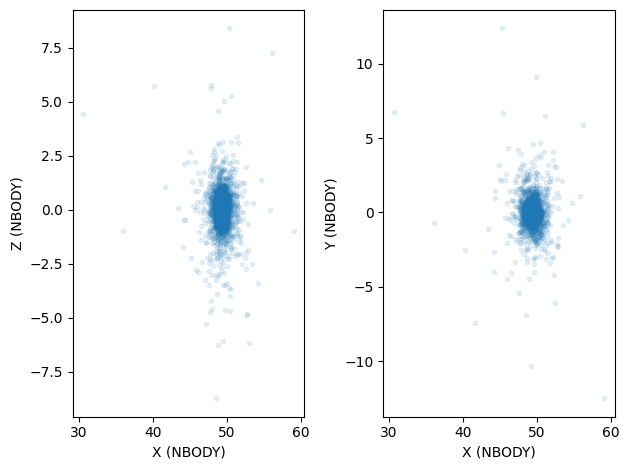

In [29]:
cluster.to_nbody()
ct.starplot(cluster)

0

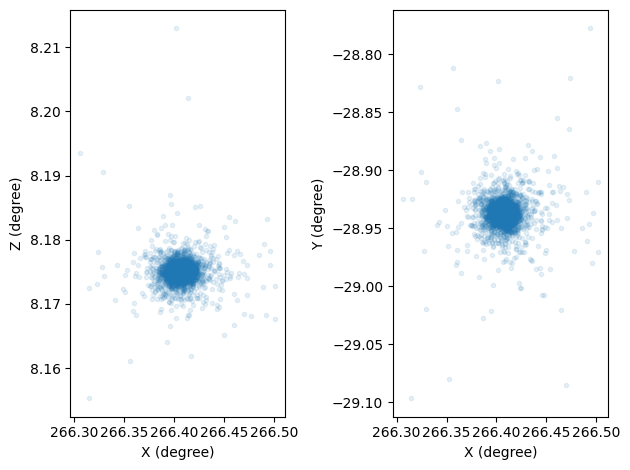

In [30]:
cluster.to_radec()
ct.starplot(cluster)

In [31]:
#At the moment, our cluster is not perfectly in virial equilibrium:
cluster.energies()
print(cluster.qvir)
#However it can be scaled such that ``cluster.qvir=-0.5``
cluster.virialize()
cluster.energies()

print('New Qv: ',cluster.qvir)


-3.62546379422e-06
New Qv:  -3.62546379422e-06


In [32]:
#At the moment, our cluster is not perfectly in virial equilibrium:
cluster_direct.energies()
print(cluster_direct.qvir)
#However it can be scaled such that ``cluster.qvir=-0.5``
cluster_direct.virialize()
cluster_direct.energies()

print('New Qv: ',cluster_direct.qvir)


-0.679262472032
New Qv:  -222.97547431


**this doesn't look correct...**

In [33]:
#How many stars have vtheta < 0 in the clustercentric coordinate system
cluster.to_cluster()
r, theta, z, vr, vtheta, vz = ct.cart_to_cyl(cluster.x,cluster.y,cluster.z,cluster.vx,cluster.vy,cluster.vz)
print('Fraction of stars with vtheta<0 =', np.sum(vtheta<0)/cluster.ntot)

#Now switch the sign of vtheta for 50% of stars with vtheta<0
print('Add rotation of 50%')
cluster.add_rotation(qrot=0.5)
r, theta, z, vr, vtheta, vz = ct.cart_to_cyl(cluster.x,cluster.y,cluster.z,cluster.vx,cluster.vy,cluster.vz)
print('Now fraction of stars with vtheta<0 =', np.sum(vtheta<0)/cluster.ntot)

Fraction of stars with vtheta<0 = 0.417666666667
Add rotation of 50%
Now fraction of stars with vtheta<0 = 0.203666666667


In [34]:
print('Half-Mass Relaxation Time: ',cluster.half_mass_relaxation_time())
print('Core Relaxation Time: ',cluster.core_relaxation_time())
print('Lagrange Radii: ',cluster.rlagrange())
print('Virial Radius: ',cluster.virial_radius())
print("projected:")
print('Half-Mass Relaxation Time: ',cluster.half_mass_relaxation_time(projected=True))
print('Core Relaxation Time: ',cluster.core_relaxation_time(projected=True))
print('Lagrange Radii: ',cluster.rlagrange(projected=True))
print('Virial Radius: ',cluster.virial_radius(projected=True))

Half-Mass Relaxation Time:  25.6407221673
Core Relaxation Time:  235.511655626
Lagrange Radii:  [0.0021819464505042135, 0.0039799356128831058, 0.0055227033290342654, 0.0070993217426422416, 0.0089569592517236285, 0.011003156248674335, 0.01380113134963605, 0.017830504632374872, 0.023336527820903091, 0.18301483396421786]
Virial Radius:  0.00986772848844
projected:
Half-Mass Relaxation Time:  25.6403322226
Core Relaxation Time:  378.691613956
Lagrange Radii:  [0.01226598780215683, 0.0048706025275751632, 0.0018236899428968713, 0.0065949989971801626, 0.0008618152357593948, 0.040876217009224829, 0.0039566486638022867, 0.0084792580463921002, 0.01230126460508266, 0.1818742003724208]
Virial Radius:  0.00898827113965


0.596556849139


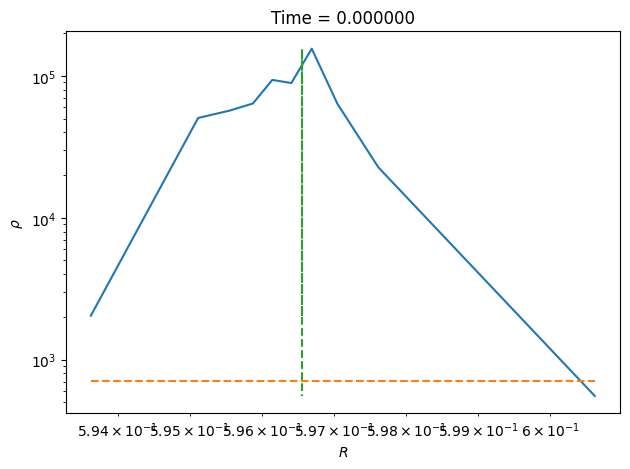

In [35]:
cluster.rcore(plot=True)
print(cluster.rc)

- Hey, no units?

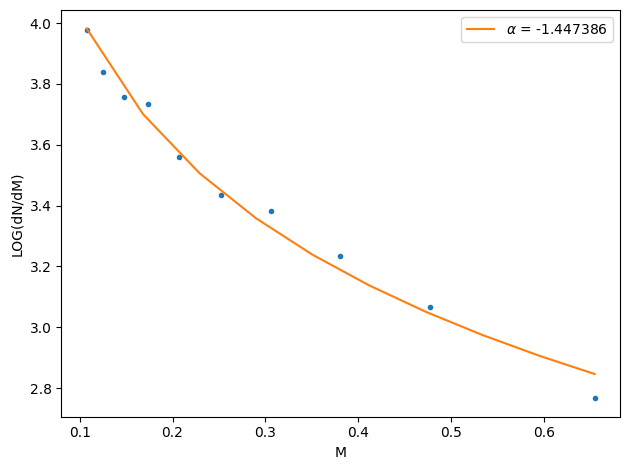

In [36]:
m_mean, m_hist, dm, alpha, ealpha, yalpha, eyalpha = ct.mass_function(cluster,mmin=0.1,mmax=0.8,plot=True)

Looks correct

In [39]:
try:
    m_mean, sigvm, eta, eeta, yeta, eyeta = ct.eta_function(cluster, plot=True)
except ValueError as err:
    print(ValueError, err)

<class 'ValueError'> 
\log_{10} \\ \sigma_v
          ^
Unknown symbol: \, found '\'  (at char 10), (line:1, col:11)
Error in callback <function _draw_all_if_interactive at 0x147403eb0> (for post_execute):


ValueError: 
\log_{10} \\ \sigma_v
          ^
Unknown symbol: \, found '\'  (at char 10), (line:1, col:11)

ValueError: 
\log_{10} \\ \sigma_v
          ^
Unknown symbol: \, found '\'  (at char 10), (line:1, col:11)

<Figure size 640x480 with 1 Axes>

**Unknown symbol error?**

Tidal Radius:  0.0106797930323
Limiting Radius:  0.0


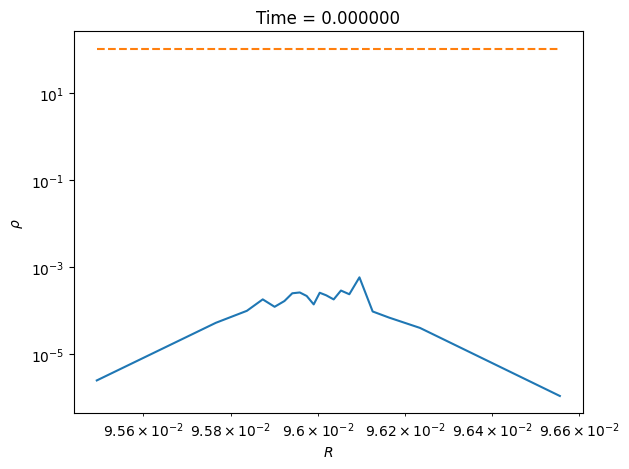

In [40]:
from galpy.potential import MWPotential2014

print('Tidal Radius: ', cluster.rtidal(pot=MWPotential2014))
print('Limiting Radius: ', cluster.rlimiting(pot=MWPotential2014,plot=True))

In [41]:
distance_to_neighbour = ct.closest_star(cluster)
print(np.amin(distance_to_neighbour))

6.17061986547e-05


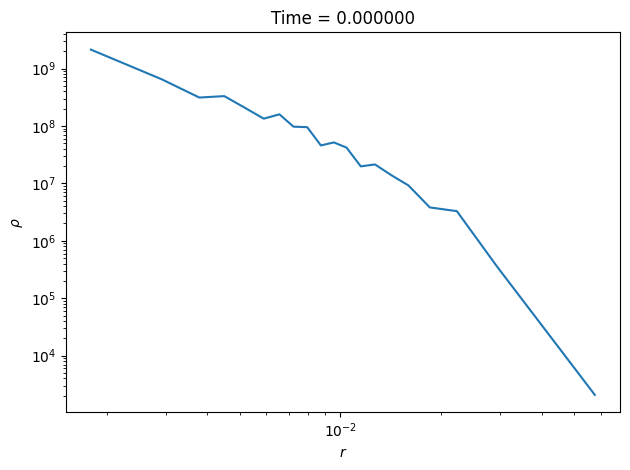

In [42]:
rprof, pprof, nprof = ct.rho_prof(cluster,plot=True)

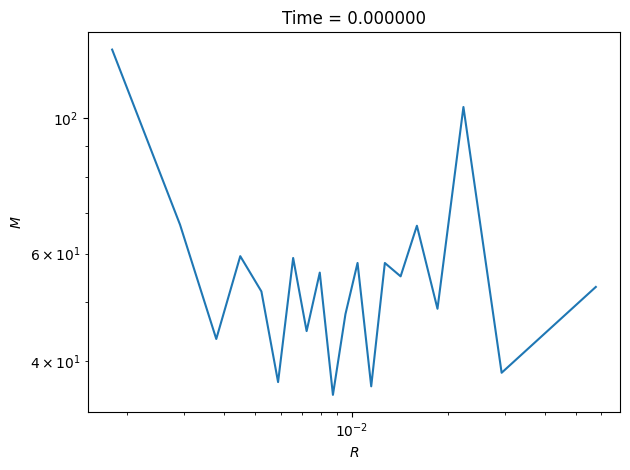

In [43]:
rprof, mprof, nprof = ct.m_prof(cluster,plot=True)

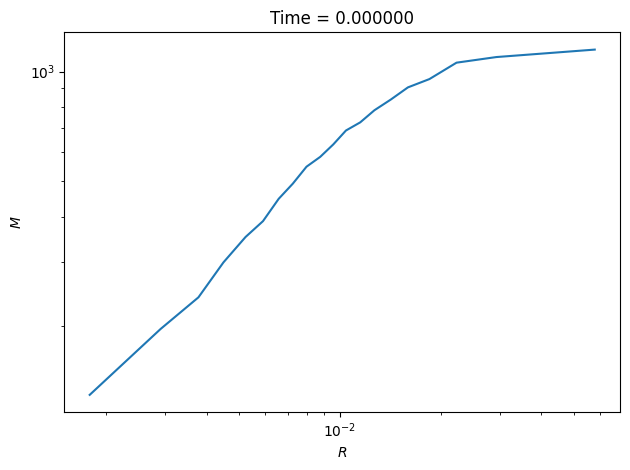

In [44]:
rprof, mprof, nprof = ct.m_prof(cluster,plot=True,cumulative=True)

0.00833944120606 256.348103907


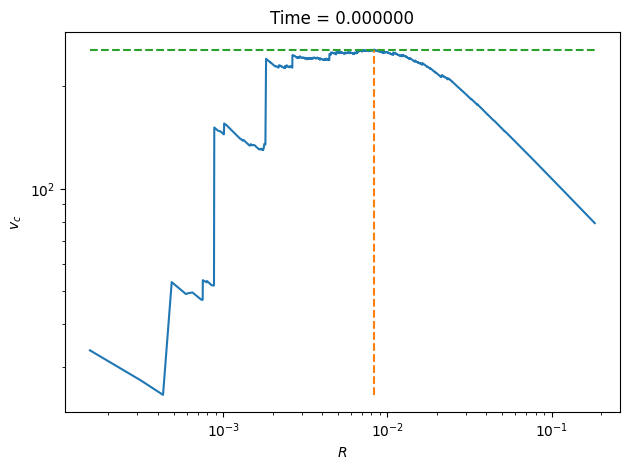

In [45]:
rprof, vcprof, rvmax, vmax = ct.vcirc_prof(cluster,plot=True,nrad=None)
print(rvmax,vmax)

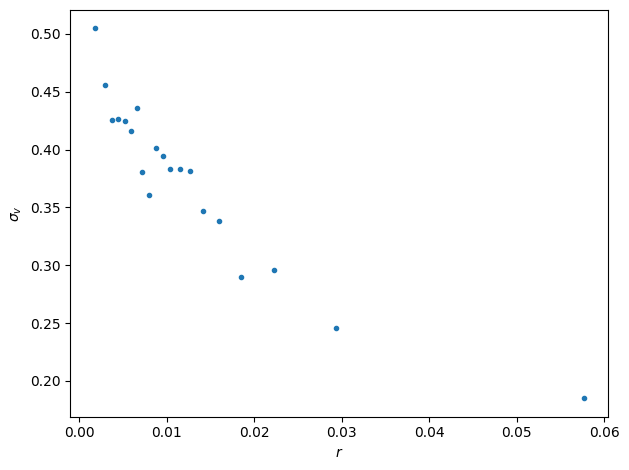

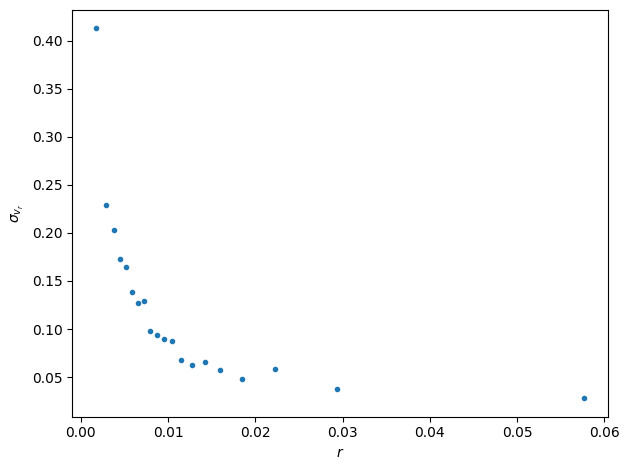

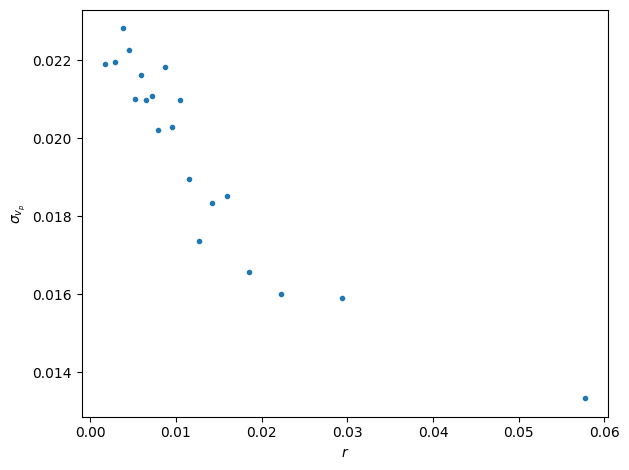

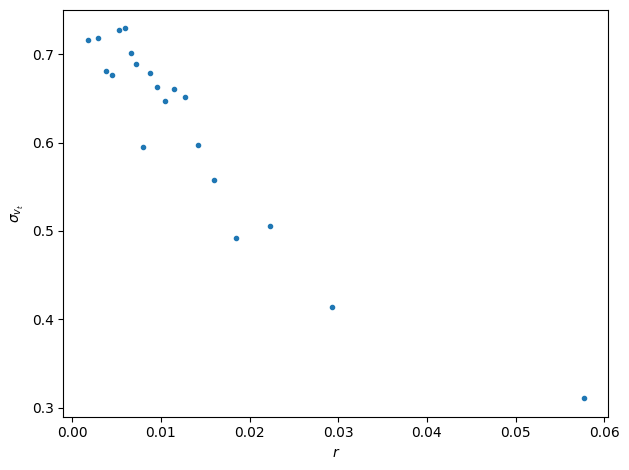

In [46]:
rprofn, sigvprof = ct.sigv_prof(cluster,plot=True)
rprofn_r, sigvprof_r = ct.sigv_prof(cluster,coord='r',plot=True)
rprofn_phi, sigvprof_phi = ct.sigv_prof(cluster,coord='phi',plot=True)
rprofn_theta, sigvprof_theta = ct.sigv_prof(cluster,coord='theta',plot=True)

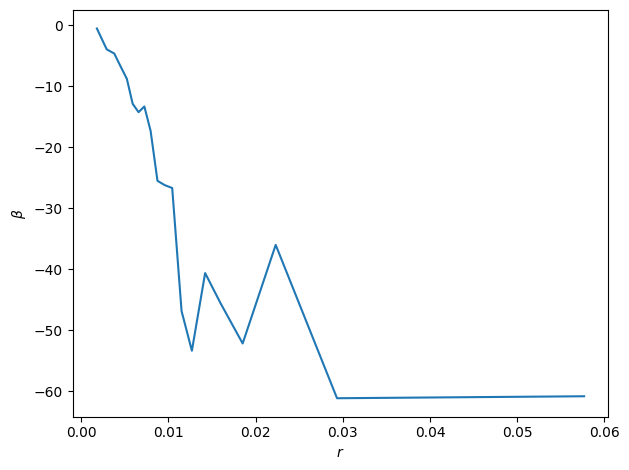

In [47]:
rprofn, betaprof = ct.beta_prof(cluster,plot=True)

**Line rather than scattered? Differs from documentation**

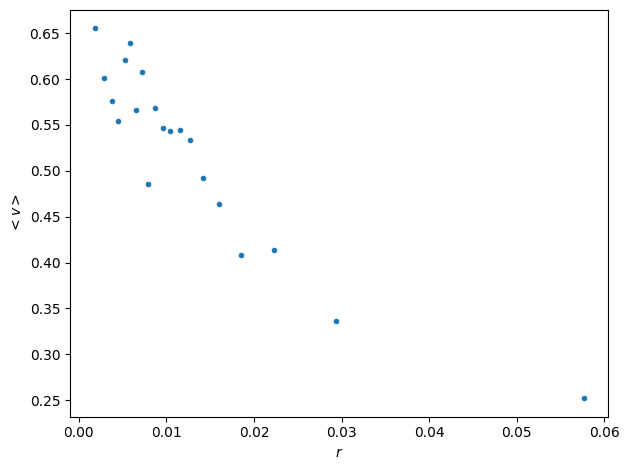

In [48]:
rprofn, vprof = ct.v_prof(cluster,plot=True)


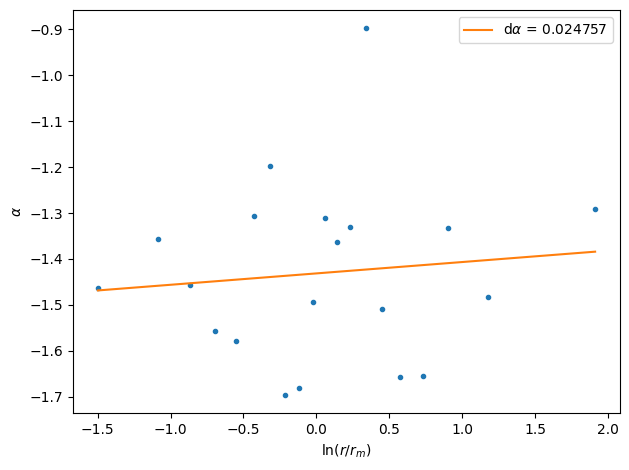

In [49]:
rprofn, aprof, dalpha, edalpha, ydalpha, eydalpha = ct.alpha_prof(cluster,mmin=0.1,mmax=0.8, plot=True, normalize=True)

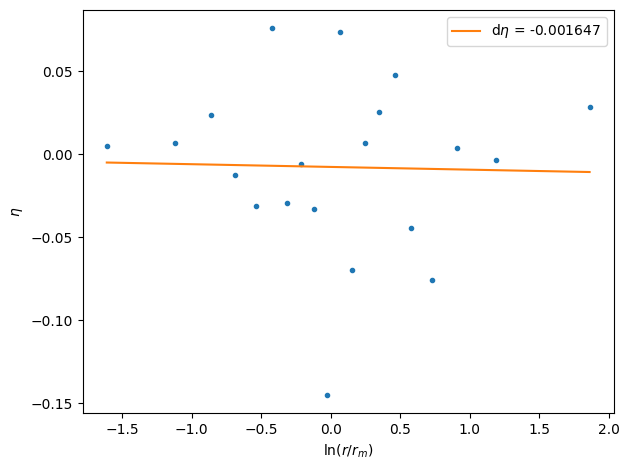

In [50]:
rprofn, eprof, deta, edeta, ydeta, eydeta = ct.eta_prof(cluster,plot=True, normalize=True)

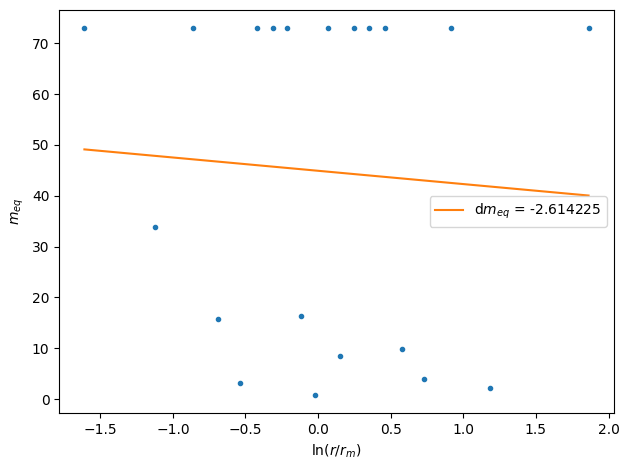

In [51]:
rprofn, meqprof, dmeq, edmeq, ydmeq, eydmeq = ct.meq_prof(cluster,plot=True, normalize=True)